# Preliminaries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## TODO:

The following code is not complete! The following are known shortcomings of the code:
1. When upgrading farms, the game currently does not check whether the upgrade is valid before attempting (i.e. you could have multiple tier 5's, a (5,5,5) farm, etc).
2. There is currently no support for monkey banks
3. (Implemented but not yet tested.) There is currently no support for the Banana Central BRF buff
4. (Implemented but not yet tested.) There is currently no support for the MWS bonus payment.
5. (Implemented but not yet tested.) The code currently does not correctly calculate payouts for farms that occur on the same round the farm is bought. The payment schedule for a farm on the round that it is bought is different than on subsequent rounds.

The following are features we'd like to add to the code:
1. Whenever GameState.advanceGameState() is run, write a log of the results to a text file (if the user desires) for debugging purposes.
2. Check for "liquidity" or the sell value of all farms/alt-eco that the player has in their posession.

## Round Length Info

We get for each round the time it takes for naturals to send and also the maximum amount of time each round can be stalled beyond the last natural bloon appearing on screen. The minimum stall time for each round is 4 seconds.

In [5]:
filepath = r"nat_send_lengths.csv"
file = pd.read_csv(filepath)
nat_send_lens = list(file['Nat Send Len'])

filepath = r"round_start_data.csv"
file = pd.read_csv(filepath)
round_starts_stall = list(file['Round Start (Stall)'])

max_stall_times = []
for i in range(len(round_starts_stall)-1):
    max_stall_times.append((round_starts_stall[i+1] - round_starts_stall[i]) - nat_send_lens[i])

## Eco Send Info

In [6]:
#The formatting of the tuples is (eco_cost, eco_gain)
eco_send_info = {
    'Zero': (0,0),
    'Grouped Reds': (150,6.75),
    'Spaced Blues': (60,3.2),
    'Grouped Blues': (240,10),
    'Spaced Greens': (93.96,4.698),
    'Grouped Greens': (525,21),
    'Spaced Yellows': (125.28,6.264),
    'Grouped Yellows': (1000,40),
    'Spaced Pinks': (186.667,9.333),
    'Grouped Pinks': (1800,69),
    'Spaced Whites': (214.2,10.71),
    'Grouped Whites': (1300,52),
    'Spaced Blacks': (264,12.8),
    'Grouped Blacks': (1406.25,56.25),
    'Spaced Purples': (262.5,12.375),
    'Grouped Purples': (3943.35,99.441),
    'Spaced Zebras': (600,27),
    'Grouped Zebras': (3000,87.5),
    'Spaced Leads': (180,8.4),
    'Grouped Leads': (1500,45),
    'Spaced Rainbows': (1199.8,51.42),
    'Grouped Rainbows': (3750,90),
    'Spaced Ceramics': (1000,26.667),
    'Grouped Ceramics': (10000,45),
}

## Monkey Farm Info

To build the MonkeyFarm class, we need the following global info for farms:
1. Upgrade costs for farms
2. Resell values for farms
3. Payout info for farms

Unforunately, the recording of data necessary for farms is quite involved!

In [7]:
farm_upgrades_costs = [[600,550,2700,16000,68000],[200,700,5500,7500,50000],[250,200,3000,13000,43500]]

farm_sell_values = {
    
    #NOTE: Any farm of level xx2 or higher has 80% sellback value!
    
    #Base Farm
    (0,0,0): 1050*0.7,
    
    ####################
    #UNCROSSPATHED FARMS
    ####################
    
    #Top path (No crosspath)
    (1,0,0): (1050+600)*0.7,
    (2,0,0): (1050+600+550)*0.7,
    (3,0,0): (1050+600+550+2700)*0.7,
    (4,0,0): (1050+600+550+2700+16000)*0.7,
    (5,0,0): (1050+600+550+2700+16000+68000)*0.7,
    
    #Middle path (No crosspath)
    (0,1,0): (1050+200)*0.7,
    (0,2,0): (1050+200+700)*0.7,
    (0,3,0): (1050+200+700+5500)*0.7,
    (0,4,0): (1050+200+700+5500+7500)*0.7,
    (0,5,0): (1050+200+700+5500+7500+50000)*0.7,
    
    #Bottom path (No crosspath)
    (0,0,1): (1050+250)*0.7,
    (0,0,2): (1050+250+200)*0.8,
    (0,0,3): (1050+250+200+3000)*0.8,
    (0,0,4): (1050+250+200+3000+13000)*0.8,
    (0,0,5): (1050+250+200+3000+13000+50000)*0.8,
    
    ######################
    #TOP CROSSPATHED FARMS
    ######################
    
    #Middle path
    (1,1,0): (1050+600+200)*0.7,
    (1,2,0): (1050+600+200+700)*0.7,
    (1,3,0): (1050+600+200+700+5500)*0.7,
    (1,4,0): (1050+600+200+700+5500+7500)*0.7,
    (1,5,0): (1050+600+200+700+5500+7500+50000)*0.7,
    
    (2,1,0): (1050+600+550+200)*0.7,
    (2,2,0): (1050+600+550+200+700)*0.7,
    (2,3,0): (1050+600+550+200+700+5500)*0.7,
    (2,4,0): (1050+600+550+200+700+5500+7500)*0.7,
    (2,5,0): (1050+600+550+200+700+5500+7500+50000)*0.7,
    
    #Bottom path
    (1,0,1): (1050+600+250)*0.7,
    (1,0,2): (1050+600+250+200)*0.8,
    (1,0,3): (1050+600+250+200+3000)*0.8,
    (1,0,4): (1050+600+250+200+3000+13000)*0.8,
    (1,0,5): (1050+600+250+200+3000+13000+50000)*0.8,
    
    (2,0,1): (1050+600+550+250)*0.7,
    (2,0,2): (1050+600+550+250+200)*0.8,
    (2,0,3): (1050+600+550+250+200+3000)*0.8,
    (2,0,4): (1050+600+550+250+200+3000+13000)*0.8,
    (2,0,5): (1050+600+550+250+200+3000+13000+50000)*0.8,
    
    #########################
    #MIDDLE CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,1,0): (1050+200+600)*0.7,
    (2,1,0): (1050+200+600+550)*0.7,
    (3,1,0): (1050+200+600+550+2700)*0.7,
    (4,1,0): (1050+200+600+550+2700+16000)*0.7,
    (5,1,0): (1050+200+600+550+2700+16000+68000)*0.7,
    
    (1,2,0): (1050+200+700+600)*0.7,
    (2,2,0): (1050+200+700+600+550)*0.7,
    (3,2,0): (1050+200+700+600+550+2700)*0.7,
    (4,2,0): (1050+200+700+600+550+2700+16000)*0.7,
    (5,2,0): (1050+200+700+600+550+2700+16000+68000)*0.7,
    
    #Bottom path
    (0,1,1): (1050+200+250)*0.7,
    (0,1,2): (1050+200+250+200)*0.8,
    (0,1,3): (1050+200+250+200+3000)*0.8,
    (0,1,4): (1050+200+250+200+3000+13000)*0.8,
    (0,1,5): (1050+200+250+200+3000+13000+50000)*0.8,
    
    (0,2,1): (1050+200+700+250)*0.7,
    (0,2,2): (1050+200+700+250+200)*0.8,
    (0,2,3): (1050+200+700+250+200+3000)*0.8,
    (0,2,4): (1050+200+700+250+200+3000+13000)*0.8,
    (0,2,5): (1050+200+700+250+200+3000+13000+50000)*0.8,
    
    #########################
    #BOTTOM CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,0,1): (1050+250+600)*0.7,
    (2,0,1): (1050+250+600+550)*0.7,
    (3,0,1): (1050+250+600+550+2700)*0.7,
    (4,0,1): (1050+250+600+550+2700+16000)*0.7,
    (5,0,1): (1050+250+600+550+2700+16000+68000)*0.7,
    
    (1,0,2): (1050+250+200+600)*0.8,
    (2,0,2): (1050+250+200+600+550)*0.8,
    (3,0,2): (1050+250+200+600+550+2700)*0.8,
    (4,0,2): (1050+250+200+600+550+2700+16000)*0.8,
    (5,0,2): (1050+250+200+600+550+2700+16000+68000)*0.8,
    
    #Middle path
    (0,1,1): (1050+250+200)*0.7,
    (0,2,1): (1050+250+200+700)*0.7,
    (0,3,1): (1050+250+200+700+5500)*0.7,
    (0,4,1): (1050+250+200+700+5500+7500)*0.7,
    (0,5,1): (1050+250+200+700+5500+7500+50000)*0.7,
    
    (0,1,2): (1050+250+200+200)*0.8,
    (0,2,2): (1050+250+200+200+700)*0.8,
    (0,3,2): (1050+250+200+200+700+5500)*0.8,
    (0,4,2): (1050+250+200+200+700+5500+7500)*0.8,
    (0,5,2): (1050+250+200+200+700+5500+7500+50000)*0.8
    
}

#In each tuple, the left entry is the payout value while the right entry is the payout frequency
farm_payout_values = {
    
    #Remember, x3x and higher farms do not payout like other farms do!
    #When a farm is upgraded to x3x, we will set its payments to (0,0)
    #When a farm is upgraded to xx5, we will set self.MWS_bonus = True
    #When a farm is upgraded to x2x or higher, its payments are multplied by 1.25!
    
    #Base Farm
    (0,0,0): (40,3),
    
    ####################
    #UNCROSSPATHED FARMS
    ####################
    
    #Top path
    (1,0,0): (40,5),
    (2,0,0): (40,7),
    (3,0,0): (40,16),
    (4,0,0): (600,5),
    (5,0,0): (3000,5),
    
    #Middle path
    (0,1,0): (40,3),
    (0,2,0): (50,3),
    
    #Bottom path
    (0,0,1): (40,3),
    (0,0,2): (40,3),
    (0,0,3): (40,14),
    (0,0,4): (160,14),
    (0,0,5): (160,14),
    
    ######################
    #TOP CROSSPATHED FARMS
    ######################
    
    #Middle path
    (1,1,0): (40,5),
    (1,2,0): (50,5),
    
    (2,1,0): (40,7),
    (2,2,0): (50,7),
    
    #Bottom path
    (1,0,1): (40,5),
    (1,0,2): (40,5),
    (1,0,3): (40,16),
    (1,0,4): (160,16),
    (1,0,5): (160,16),
    
    (2,0,1): (40,7),
    (2,0,2): (40,7),
    (2,0,3): (40,18),
    (2,0,4): (160,18),
    (2,0,5): (160,18),
    
    #########################
    #MIDDLE CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,1,0): (40,5),
    (2,1,0): (40,7),
    (3,1,0): (40,16),
    (4,1,0): (600,5),
    (5,1,0): (3000,5),
    
    (1,2,0): (50,5),
    (2,2,0): (50,7),
    (3,2,0): (50,16),
    (4,2,0): (750,5),
    (5,2,0): (3750,5),
    
    #Bottom path
    (0,1,1): (40,3),
    (0,1,2): (40,3),
    (0,1,3): (40,14),
    (0,1,4): (160,14),
    (0,1,5): (160,14),
    
    (0,2,1): (50,3),
    (0,2,2): (50,3),
    (0,2,3): (50,14),
    (0,2,4): (200,14),
    (0,2,5): (200,14),
    
    #########################
    #BOTTOM CROSSPATHED FARMS
    #########################
    
    #This is admittedly redundant but I do this beacuse it makes the code easier to read/use
    
    #Top path
    (1,0,1): (40,5),
    (2,0,1): (40,7),
    (3,0,1): (40,16),
    (4,0,1): (600,5),
    (5,0,1): (3000,5),
    
    (1,0,2): (40,5),
    (2,0,2): (40,7),
    (3,0,2): (40,16),
    (4,0,2): (600,5),
    (5,0,2): (3000,5),
    
    #Middle path
    (0,1,1): (40,3),
    (0,2,1): (50,3),
    
    (0,1,2): (40,3),
    (0,2,2): (50,3)
    
}

In [8]:
def dprint(phr, act = False):
    if act == True:
        print(phr)
        
def writeLog(lines, filename = 'log'):
    with open(filename + '.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

# Round Lengths Class

TODO: To faciliate more flexible code when performing optimizations, construct a class RoundInfo() dedicated to the computation of round lengths and round start times 

In [ ]:
#WARNING: This class is not yet fully built and not implemented in any examples right now. Do NOT attempt to use it.
class RoundInfo():
    def __init__(self, initial_state):
        
    

# Game State Class

The game state class is an instance of battles 2 in action!

In [174]:
class GameState():
    def __init__(self, initial_state):
        
        ###########################
        #PART 1: INITIAL PARAMETERS
        ###########################
        
        #To ensure the code runs properly, we'll create a log file to track changes made by each method
        self.logs = []
        
        #Set to true to print debug statements
        self.debug = initial_state.get('Debug')
        
        #Initial cash and eco
        self.cash = initial_state.get('Cash')
        self.eco = initial_state.get('Eco')
        
        #Eco send info
        eco_send = initial_state.get('Eco Send')
        self.eco_cost = eco_send_info[eco_send][0]
        self.eco_gain = eco_send_info[eco_send][1]
        
        #Eco queue info
        self.eco_queue = initial_state.get('Eco Queue')
        
        #~~~~~
        #FARMS
        #~~~~~
        
        # self.farms is a dictionary object whose keys are integers and whose values are MonkeyFarm() instances
        # Whenever a farm is purchased, it will be assigned the key self.key, and then key will be incremented by one
        # DEVELOPER'S NOTE: This structure is used over just a list so I can support "compound transactions", such selling into BRF, MWS, etc.
        self.farms = initial_state.get('Farms')
        self.key = 0
        
        self.tellers = initial_state.get('Tellers')
        self.teller_key = 0
        
        self.supply_drops = initial_state.get('Supply Drops')
        self.elite_sniper = initial_state.get('Elite Sniper') #If this is a number, then the number is the index of the elite sniper 
        
        #Upgrade queue
        self.buy_queue = initial_state.get('Buy Queue')
        self.buy_cost = None
        self.buffer = 0
        self.min_buy_time = 0
        
        #Stall factor info
        self.stall_factor = initial_state.get('Stall Factor')
        
        #Banana Central BRF buff info
        self.BRF_buff = False
        
        #Location of the MWS companion farm (if it exists) 
        self.MWS_bonus_index = None
        
        #Fail-safes
        if self.farms is None:
            self.farms = {}
        if self.buy_queue is None:
            self.buy_queue = []
        if self.eco_queue is None:
            self.eco_queue = []
        
        #Compute the time each round starts based on the given stall factor
        #Then, compute the current round we are on given the current game time
        
        val = 0
        self.round_starts = [0]
        for i in range(len(nat_send_lens)):
            round_len = nat_send_lens[i] + (1-self.stall_factor)*4 + self.stall_factor*max_stall_times[i]
            val += round_len
            self.round_starts.append(val)
            #print("Round %s is %s seconds long"%(str(i),round_len))
        
        #In most cases, the user will probably want to indicate a starting round rather than a starting time
        #If a starting round is given, compute the starting time based on the round starts
        #A round value of 15.5 means "halfway through round 15"
        if initial_state.get('Game Round') is not None:
            starting_round = initial_state.get('Game Round')
            self.current_time = self.computeTimeFromRound(starting_round)
        else:
            self.current_time = initial_state.get('Game Time')
        
        self.round = self.getRoundFromTime(self.current_time)
        
        #As the Game State evolves, I'll use these arrays to track how cash and eco have changed over time
        self.time_states = [self.current_time]
        self.cash_states = [self.cash] 
        self.eco_states = [self.eco]
        
        self.logs.append("MESSAGE FROM GameState.__init__(): ")
        self.logs.append("Initialized Game State!")
        self.logs.append("The current game round is %s"%(self.round))
        self.logs.append("The current game time is %s seconds"%(self.current_time))
        self.logs.append("The game round start times are given by %s \n"%(self.round_starts))
        
    def getRoundFromTime(self, time):
        ind = 0
        while self.round_starts[ind] <= time:
            ind += 1
        #self.logs.append("Mapped time %s to round %s"%(time,ind-1))
        return ind - 1
    
    def computeTimeFromRound(self, round_val):
        frac_part = round_val - np.floor(round_val)
        time = (1-frac_part)*self.round_starts[int(np.floor(round_val))] + frac_part*self.round_starts[int(np.ceil(round_val))]
        #self.logs.append("Mapped round %s to time %s"%(round_val,time))
        return time
        
    def viewCashEcoHistory(self):
        self.logs.append("MESSAGE FROM GameState.viewCashEcoHistory():")
        self.logs.append("Graphing history of cash and eco!")
        fig, ax = plt.subplots(2)
        fig.set_size_inches(6,9)
        ax[0].plot(self.time_states, self.cash_states, label = "Cash")
        ax[1].plot(self.time_states, self.eco_states, label = "Eco")
        
        #For easy reference, let's also mark on these graphs where the rounds start
        
        cash_min = min(self.cash_states)
        eco_min = min(self.eco_states)
        
        cash_max = max(self.cash_states)
        eco_max = max(self.eco_states)
        round_to_graph = self.getRoundFromTime(self.time_states[0]) + 1
        while self.round_starts[round_to_graph] <= self.time_states[-1]:
            self.logs.append("Graphing round %s, which starts at time %s"%(str(round_to_graph),str(self.round_starts[round_to_graph])))
            ax[0].plot([self.round_starts[round_to_graph], self.round_starts[round_to_graph]],[cash_min, cash_max], label = "R" + str(round_to_graph) + " start")
            ax[1].plot([self.round_starts[round_to_graph], self.round_starts[round_to_graph]],[eco_min, eco_max], label = "R" + str(round_to_graph) + " start")
            round_to_graph += 1
        
        ax[0].set_title("Cash vs Time")
        ax[1].set_title("Eco vs Time")
        
        ax[0].set_ylabel("Cash")
        ax[1].set_ylabel("Eco")
        
        ax[1].set_xlabel("Time (seconds)")
        
        ax[0].legend()
        ax[1].legend()
        
        fig.tight_layout()
        self.logs.append("Successfully generated graph! \n")
    
    def changeStallFactor(self,stall_factor):
        self.logs.append("MESSAGE FROM GameState.changeStallFactor():")
        self.logs.append("Changing the stall factor from %s to %s"%(self.stall_factor,stall_factor))
        self.logs.append("The old round start times were %s"%(self.round_starts))
        
        #Modifies the stall factor mid-game by adjusting the length of remaining rounds
        val = self.round_starts[self.round]
        #Check whether the current round should have its stall time modified or not
        
        if val < self.round_starts[self.round] + nat_send_lens[self.round]:
            #Yes, the current round should have its stall time modified
            start_ind = self.round
        else:
            #No, the current round should not have its stall time modified
            start_ind = self.round+1
            val = self.round_starts[start_ind]
        
        for i in range(start_ind, len(nat_send_lens)-1):
            #print("Trying index %s"%(str(i)))
            val += nat_send_lens[i] + (1-stall_factor)*4 + stall_factor*max_stall_times[i]
            self.round_starts[i+1] = val
        
        self.logs.append("The new round start times are %s"%(self.round_starts))
        self.logs.append("The current game round is %s"%(self.round))
        self.logs.append("The current game time is %s seconds"%(self.current_time))
        self.logs.append("The next round starts at time %s \n"%(self.round_starts[self.round+1]))
    
    def changeEcoSend(self,send_name):
        self.eco_cost = eco_send_info[send_name][0]
        self.eco_gain = eco_send_info[send_name][1]
        self.logs.append("Modified the eco send to %s"%(send_name))
        
    def fastForward(self, target_time = None, target_round = None, interval = 1):
        self.logs.append("MESSAGE FROM GameState.fastForward: ")
        
        # If a target round is given, compute the target_time from that
        if target_round is not None:
            target_time = self.computeTimeFromRound(target_round)
            
        #A fail-safe to prevent the code from trying to go backwards in time
        if target_time < self.current_time:
            target_time = self.current_time
        
        while self.current_time < target_time:
            intermediate_time = min(np.floor((self.current_time + interval)/interval)*interval,target_time)
            self.logs.append("Advancing game to time %s"%(intermediate_time))
            self.advanceGameState(target_time = intermediate_time)
            self.logs.append("----------")
        
        self.logs.append("Advanced game state to round " + str(self.round))
        self.logs.append("The current time is " + str(self.current_time))
        self.logs.append("The next round starts at time " + str(self.round_starts[self.round+1]))
        self.logs.append("Our new cash and eco is given by (%s,%s) \n"%(np.round(self.cash,2),np.round(self.eco,2)))
            
    def advanceGameState(self, target_time = None, target_round = None):
        self.logs.append("MESSAGE FROM GameState.advanceGameState: ")
        # Advance the game to the time target_time, 
        # computing the new money and eco amounts at target_time
        
        # If a target round is given, compute the target_time from that
        if target_round is not None:
            target_time = self.computeTimeFromRound(target_round)
            
        #A fail-safe to prevent the code from trying to go backwards in time
        if target_time < self.current_time:
            target_time = self.current_time
            
        if len(self.eco_queue) > 0:
            if target_time >= self.eco_queue[0][0]:
                target_time = self.eco_queue[0][0]
                self.logs.append("Warning! An eco change is coming at time %s. Adjusting the target time."%(target_time))
        
        ####################################
        #PART 1: COMPUTATION OF PAYOUT TIMES
        ####################################
        
        #Entries in payout_times take the format (time, source)
        payout_times = []
        
        #First, let's identify payouts from eco
        eco_time = 6*(np.floor(self.current_time/6)+1)
        while eco_time <= target_time:
            payout_times.append((eco_time,'eco'))
            eco_time += 6

        #Next, let's do supply drops
        if self.supply_drops is not None:
            for i in range(len(self.supply_drops)):
                supply_drop  = self.supply_drops[i]
                if i == self.elite_sniper:
                    payout_source = 'elite sniper'
                else:
                    payout_source = 'supply drop'

                #Determine the earliest supply drop that could occur within the interval of interest (self.current_time,target_time]
                drop_index = max(1,np.ceil(1 + (self.current_time - supply_drop - 20)/40))
                supply_drop_time = supply_drop + 20 + 40*(drop_index-1)
                while supply_drop_time <= target_time:
                    payout_times.append((supply_drop_time,payout_source))
                    supply_drop_time += 40
            
        # Next, let's do monkey tellers!
        # WARNING: In order to correctly compute interest for monkey banks, this section *must* be placed before the section covering farm payments
        if len(self.tellers) > 0:
            #At the start of each round, each teller will interact with its corresponding bank, awarding a payment $400 and then giving 20% interest.
            #In this part, we record the specific times tellers interact with their banks.
            self.inc = 1
            while self.round_starts[self.round + self.inc] <= target_time:
                teller_time = self.round_starts[self.round + self.inc]
                for teller in self.tellers.values():
                    payout_times.append((teller_time, teller))
                self.inc += 1
                    
                
        
        #Next, let's do farms!
        if len(self.farms) > 0:
            for farm in self.farms.values():
                farm_purchase_round = self.getRoundFromTime(farm.purchase_time)
                self.inc = 0
                self.flag = False
                while self.flag == False:
                    #If computing farm payments on the same round as we are currently on, precompute the indices the for loop should go through.
                    #NOTE: This is not necessary at the end because the for loop terminates when a "future" payment is reached.
                    if self.inc == 0:
                        if self.round > farm_purchase_round:
                            #When the farm was purchased on a previous round
                            round_time = self.current_time - self.round_starts[self.round]
                            loop_start = int(np.floor(farm.payout_frequency*round_time/nat_send_lens[self.round]) + 1)
                            loop_end = farm.payout_frequency
                        else: #self.round == farm_purhcase_round
                            #When the farm was purchased on the same round as we are currently on
                            loop_start = int(np.floor(farm.payout_frequency*(self.current_time - farm.purchase_time)/nat_send_lens[self.round]-1)+1)
                            loop_end = int(np.ceil(farm.payout_frequency*(1 - (farm.purchase_time - self.round_starts[self.round])/nat_send_lens[self.round])-1)-1)
                    else:
                        loop_start = 0
                        loop_end = farm.payout_frequency
                    
                    #self.logs.append("Precomputed the loop indices to be (%s,%s)"%(loop_start,loop_end))
                    #self.logs.append("Now computing payments at round %s"%(self.round + self.inc))
                    for i in range(loop_start, loop_end):
                        #Precompute the value i that this for loop should start at (as opposed to always starting at 0) to avoid redundant computations
                        #Farm payout rules are different for the round the farm is bought on versus subsequent rounds
                        if self.round + self.inc == farm_purchase_round:
                            farm_time = farm.purchase_time + (i+1)*nat_send_lens[self.round + self.inc]/farm.payout_frequency
                        else:
                            farm_time = self.round_starts[self.round + self.inc] + i*nat_send_lens[self.round + self.inc]/farm.payout_frequency
                        
                        #Check if the payment time occurs within our update window. If it does, add it to the payout times list
                        if farm_time <= target_time and farm_time > self.current_time:
                            #self.logs.append("Appending farm payout at time %s"%(farm_time))
                            payout_times.append((farm_time,farm))
                        elif farm_time > target_time:
                            #self.logs.append("The payout time of %s is too late! Excluding payout time!"%(farm_time))
                            self.flag = True
                            break
                    self.inc += 1
                
        #print(payout_times)
        #Sort the payout times by the order they occur in
        payout_times = sorted(payout_times, key=lambda x: x[0]) 
        #dprint(payout_times,self.debug)
        #print(payout_times)
        
        ##############################
        #PART 2: COMPUTATION OF WEALTH
        ##############################
        
        time = self.current_time
        buy_time = target_time
        for payout in payout_times:
            
            if payout[0] > buy_time:
                self.logs.append("Terminating advanceGameState early due to a purchase sequence.")
                target_time = time
                break
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #First, compute the impact of eco
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            if self.eco_cost > 0:
                self.cash = self.cash - min(self.cash,self.eco_cost*(payout[0]-time)/6)
                self.eco = self.eco + min((payout[0]-time)/6, self.cash/self.eco_cost)*self.eco_gain
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
            #Next, award the payout at the given time
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            #self.logs.append("(%s,%s)"%(payout[0],payout[1]))
            if type(payout[1]) is MonkeyFarm:
                
                #Farm payouts are straightforward except for two cases:
                # 1. Accounting for the BRF buff
                # 2. Monkey Bank payments
                # The first two parts of this if/then construct are meant for the two special cases above
                
                farm = payout[1]
                if self.BRF_buff == True and farm.upgrades[0] == 4:
                    self.cash += farm.payout_amount*1.25
                    self.logs.append("Awarded payment %s at time %s"%(farm.payout_amount*1.25,np.round(payout[0],2)))
                elif farm.upgrades[1] >= 3 and farm.upgrades[1] < 6:
                    if farm.account_value + farm.payout_amount <= farm.max_account_value:
                        farm.account_value += farm.payout_amount
                        self.logs.append("Added %s to a farm's bank account at time %s"%(farm.payout_amount,np.round(payout[0],2)))
                    else: 
                        farm.account_value = farm.max_account_value
                        self.logs.append("Tried adding %s to a farm's bank account at time %s but maxed it out instead!"%(farm.payout_amount,np.round(payout[0],2)))
                else:
                    self.cash += farm.payout_amount
                    self.logs.append("Awarded payment %s at time %s"%(farm.payout_amount,np.round(payout[0],2)))
                    
                #If the payout belongs to a Monkey Bank, instead of incrementing cash, increment the amount of money in the bank
                
            elif type(payout[1]) is MonkeyTeller:
                #The bank teller is a special "companion" class designed to correctly facilitate the start-of-round payment and interest bonus applied to banks
                teller = payout[1]
                farm = self.farms[teller.farm_index]
                
                #Award 400 dollars to the farm's bank account and also 20% interest
                farm.account_value += 400
                farm.account_value *= 1.2
                self.logs.append("Awarded start-of-round bonus to monkey bank at time %s!"%(np.round(payout[0],2)))
                
                if farm.account_value > farm.max_account_value:
                    self.logs.append("Reached the bank's max capacity!"%(np.round(payout[0],2)))
                    farm.account_value = farm.max_account_value
                
            elif payout[1] == 'eco':
                self.cash += self.eco
                self.logs.append("Awarded payment %s at time %s"%(np.round(self.eco,2),np.round(payout[0],2)))
            elif payout[1] == 'supply drop':
                self.cash += 2000
                self.logs.append("Awarded payment 2000 at time %s"%(np.round(payout[0],2)))
            elif payout[1] == 'elite sniper':
                self.cash += 5000
                self.logs.append("Awarded payment 5000 at time %s"%(np.round(payout[0],2)))
                #There is no need to modify the cash and eco for tracer payments
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #Now, check whether we can perform the next buy in the buy queue
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            while len(self.buy_queue) > 0:
                #If necessary, pull out the first object in the buy queue and check its cost
                
                purchase_info = self.buy_queue[0]
                if self.buy_cost == None:
                    self.buy_cost = 0
                    for dict_obj in purchase_info:
                        if dict_obj['Type'] == 'Buy Defense':
                            self.buy_cost += dict_obj['Cost']
                        elif dict_obj['Type'] == 'Buy Farm':
                            self.buy_cost += 1050
                        elif dict_obj['Type'] == 'Upgrade Farm':
                            ind = dict_obj['Index']
                            path = dict_obj['Path']
                            farm = self.farms[ind]
                            self.buy_cost += farm_upgrades_costs[path][farm.upgrades[path]]
                        elif dict_obj['Type'] == 'Sell Farm':
                            ind = dict_obj['Index']
                            farm = self.farms[ind]
                            self.buy_cost -= farm_sell_values[tuple(farm.upgrades)]
                        
                        #Read the buffer associated with the buy if any
                        #NOTE: Only one object in purchase_info should have buffer info
                        #If there are multiple buffers, the code rectifies the matter by
                        #adding them all together
                        if dict_obj.get('Buffer') is not None:
                            self.buffer += dict_obj.get('Buffer')
                        
                        #Read the minimum buy time associated with the buy if any
                        #NOTE: Only one object in purchase info should have minimum buy time info
                        #If there are multiple values, the code will pick the latest value
                        min_buy_time = dict_obj.get('Minimum Buy Time')
                        if min_buy_time is not None:
                            if min_buy_time > self.min_buy_time:
                                self.min_buy_time = min_buy_time
                        
                #Now, check if we have enough money to do the buy
                if self.cash >= self.buy_cost + self.buffer and self.current_time >= self.min_buy_time:
                    #If we do, perform the buy!
                    buy_time = payout[0]
                    self.logs.append("We have %s cash! That's enough to perform the next buy, which costs %s and has a buffer of %s!"%(np.round(self.cash,2), np.round(self.buy_cost,2),np.round(self.buffer,2)))
                    
                    self.cash -= self.buy_cost
                    for dict_obj in purchase_info:
                        if dict_obj['Type'] == 'Buy Farm':
                            self.logs.append("Purchasing farm!")
                            farm_info = {
                                'Purchase Time': self.current_time,
                                'Upgrades': [0,0,0]
                            }
                            farm = MonkeyFarm(farm_info)
                            
                            self.farms[self.key] = farm
                            self.key+= 1
                            
                        elif dict_obj['Type'] == 'Upgrade Farm':
                            ind = dict_obj['Index']
                            path = dict_obj['Path']
                            
                            self.logs.append("Upgrading path %s of the farm at index %s"%(path, ind))
                            farm = self.farms[ind]
                            farm.upgrades[path] += 1
                            
                            #Update the payout information of the farm
                            farm.payout_amount = farm_payout_values[tuple(farm.upgrades)][0]
                            farm.payout_frequency = farm_payout_values[tuple(farm.upgrades)][1]

                            #Update the sellback value of the farm
                            farm.sell_value = farm_sell_values[tuple(farm.upgrades)]
                            
                            self.logs.append("The new farm has upgrades (%s,%s,%s)"%(farm.upgrades[0],farm.upgrades[1],farm.upgrades[2]))
                            
                            #WARNING: We must account for the special cases of a Banana Central or MWS purchase!
                            #If the resulting farm is a MWS, create a "companion farm" which accounts for the round-start bonus
                            if farm.upgrades[2] == 5:
                                self.logs.append("The new farm is a MWS! Building the companion farm.")
                                farm_info = {
                                'Purchase Time': self.current_time,
                                'MWS Bonus': True
                                }
                                farm = MonkeyFarm(farm_info)
                                self.farms[-1] = farm
                                self.MWS_bonus_index = -1

                            #If the resulting farm is a Banana Central, activate the BRF buff, giving them 25% more payment amount
                            if farm.upgrades[0] == 5:
                                self.logs.append("The new farm is a Banana Central!")
                                self.BRF_buff = True
                            
                        elif dict_obj['Type'] == 'Sell Farm':
                            ind = dict_obj['Index']
                            self.logs.append("Selling the farm at index %s"%(ind))
                            #WARNING: We must account for the special cases of a Banana Central or MWS Sell!
                            #If the farm being sold is a MWS, we must *also* remove the companion farm accounting for the start-of-round bonus
                            if farm.upgrades[2] == 5 and self.MWS_bonus_index is not None:
                                self.logs.append("The farm we're selling is an MWS! Removing the companion farm.")
                                self.farms.pop(self.MWS_bonus_index)
                                self.MWS_bonus_index = None

                            #If the farm being sold is a Banana Central, we must turn off the BRF buff
                            if farm.upgrades[0] == 5:
                                self.logs.append("The farm we're selling is a Banana Central! Removing the BRF buff.")
                                self.BRF_buff = False
                            
                            self.farms.pop(ind)
                            
                    #Now, we have finished the for loop through purchase_info and thus correctly performed the buys
                    #Remove the buy from the queue and set self.buy_cost to None so the code knows next time to re-compute
                    #the buy cost for the next item in the buy queue
                    self.buy_cost = None
                    self.buffer = 0
                    self.buy_queue.pop(0)
                    self.logs.append("Completed the buy operation! The buy queue now has %s items remaining in it"%(len(self.buy_queue)))
                else:
                    #If we can't afford the buy, break the while loop
                    #self.logs.append("We can't afford the buy! Terminating the buy queue while loop")
                    break
            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #Record the cash & eco history and advance the game time
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            #print("New cash and eco is (%s,%s)"%(np.round(self.cash,2), np.round(self.eco,2)))
            self.time_states.append(payout[0])
            self.cash_states.append(self.cash)
            self.eco_states.append(self.eco)
            self.logs.append("Recorded cash and eco values (%s,%s) at time %s"%(np.round(self.cash,2),np.round(self.eco,2),np.round(payout[0],2)))
            
            time = payout[0]
            
            #end of for loop

        
        # After going through the for loop, we have accounted for all payments that could occur in the time period of interest
        # and also performed any purchases in our buy queue along the way. 
        # The last step of PART 2 is to account for the loss in cash and gain in eco from the final payment to the target_time
        # If the for loop terminated prematurely because of a buy, this step is not necessary since the target time and current time would be both the same in this instance
        
        if self.eco_cost > 0:
            self.cash = self.cash - min(self.cash,self.eco_cost*(target_time-time)/6)
            self.eco = self.eco + min((target_time-time)/6, self.cash/self.eco_cost)*self.eco_gain

        self.time_states.append(target_time)
        self.cash_states.append(self.cash)
        self.eco_states.append(self.eco)
            
        ####################################
        #PART 3: UPDATE GAME TIME PARAMETERS
        ####################################
        
        #Determine the round we are in now
        self.current_time = target_time
        while self.round_starts[self.round] <= self.current_time:
            self.round += 1
        self.round -= 1
        
        #Update the eco send, if necessary
        if len(self.eco_queue) > 0:
            if target_time >= self.eco_queue[0][0]:
                self.changeEcoSend(self.eco_queue[0][1])
                self.logs.append("Changed the eco send to %s"%(self.eco_queue[0][1]))
                self.eco_queue.pop(0)
        
        #self.logs.append("Advanced game state to round " + str(self.round))
        #self.logs.append("The current time is " + str(self.current_time))
        #self.logs.append("The next round starts at time " + str(self.round_starts[self.round+1]))
        #self.logs.append("Our new cash and eco is given by (%s,%s) \n"%(np.round(self.cash,2),np.round(self.eco,2)))
        
        

# The Monkey Farm Class

The payout of farms (for the most part) can be described by a payout amount and a payout frequency. There are three exceptions to this:
1. Monkey Wall Street - The MWS has an additional start-of-round payment of 10000 dollars on top of its usual payment schedule. To account for this start-of-round bonus, we will do the following: Whenever a farm is upgraded to xx5, we will create an additional farm with payout frequency 1 and payout amount 10000. This "companion" farm will be marked with the self.MWS_bonus flag. If the player decides to sell their farm, we will search for this companion farm and delete it also.

2. Monkey banks - Monkey banks operate on entirely different rules. For now, because they are not commonly used in meta gameplay, I will ignore them for the time being.
3. Banana Central - Banana central contains a buff which causes all BRF's to be worth 20% more. In order to accurately track this buff, we must set a variable within the *Game State* class that applies this buff when BC is bought (and removes it when it's sold). 

Now it's time to define the MonkeyFarm class!

In [120]:
class MonkeyFarm():
    def __init__(self, initial_state):
        
        #self.upgrades is an array [i,j,k] representing the upgrade state of the farm
        #EXAMPLE: [4,2,0] represents a Banana Research Facility with Valuable Bananas
        
        if initial_state.get('MWS Bonus') == True:
            #WARNING: the MWS Bonus companion farm is only a helper object designed to faciliate correct payout of the xx5 farm
            #DO NOT MANIPULATE THIS FARM LIKE OTHER FARMS
            
            self.MWS_bonus = True
            self.purchase_time = initial_state.get('Purchase Time')
            self.payout_amount = 10000
            self.payout_frequency = 1
            self.upgrades = [6,6,6] #This is admittedly a cheap cop-out to work around a known flaw in the code
        else:
            self.upgrades = initial_state.get('Upgrades')
            self.sell_value = farm_sell_values[tuple(self.upgrades)]

            self.purchase_time = initial_state.get('Purchase Time')
            self.payout_amount = farm_payout_values[tuple(self.upgrades)][0]
            self.payout_frequency = farm_payout_values[tuple(self.upgrades)][1]
            
            self.MWS_bonus = False
            self.bank = False
            
            #If the farm is a bank, mark is as such
            if self.upgrades[1] >= 3:
                self.bank = True
        
        self.account_value = 0
        self.max_account_value = 14000
        self.BRF_buff = False
        
class MonkeyTeller():
    def __init__(self, initial_state):
        #The
        self.bank_index = 

# Simulations

We now run the code in a variety of different game scenarios. The goal of this section is to communicate to practioners how a front-end for this simulation may be coded. Given the level of sophistication of the problem at hand, the code is relatively easy to use. To begin, we introduce some helper functions to simplify the code-writing process.

In [167]:
def buyFarm(buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Farm',
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def upgradeFarm(index, path, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Upgrade Farm',
        'Index': index,
        'Path': path,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def sellFarm(index):
    return {
        'Type': 'Sell Farm',
        'Index': index
    }

def buyDefense(cost, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Defense',
        'Cost': cost,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

# WARNING: This function is for declaring farms in the initial game state. 
# Do NOT use it to add farms during simulation
def initFarm(purchase_time, upgrades = [0,0,0]):
    farm_info =  {
        'Purchase Time': purchase_time,
        'Upgrades': upgrades
    }
    return MonkeyFarm(farm_info)
    

## MWS Into Banana Central: Compound Purchases

We demonstrate a typical build into a R27 Banana Central starting from Round 24. We assume we are halfway through the round in a half-stalled game in possession of 2 x 204 farms + 1 x 420 farm. The flowchart for Banana Central proceeds as follows

Round | Action to Take
---|---
24 | (EOR) Sell 1 x 420 + 1 x 204 farm into 205 farm
~25 | Build 1 x 420 farm
~26 | Build 1 x 420 farm
~27 | Sell 205 farm into 520 farm

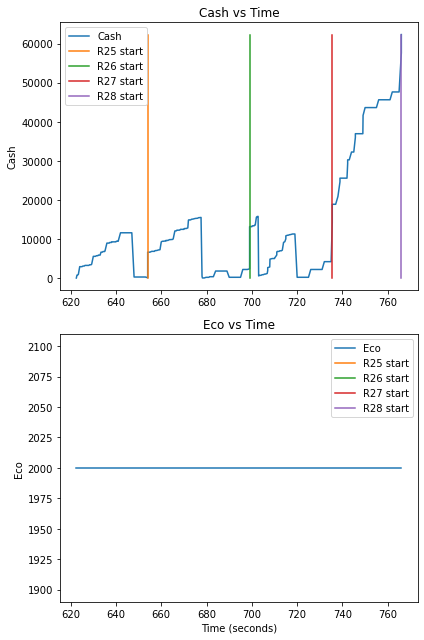

In [164]:
##############################
# DEFINING INITIAL GAME PARAMS
##############################

initial_state_game = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': 'Zero',
    'Stall Factor': 0.5,
    'Game Round': 24.5,
    'Debug': True
}
game_state = GameState(initial_state_game)

farm_0_info = {
    'Purchase Time': 0,
    'Upgrades': [4,2,0]
}
farm_0 = MonkeyFarm(farm_0_info)

farm_1_info = {
    'Purchase Time': 1,
    'Upgrades': [2,0,4]
}
farm_1 = MonkeyFarm(farm_1_info)

farm_2_info = {
    'Purchase Time': game_state.computeTimeFromRound(24.5),
    'Upgrades': [2,0,4]
}
farm_2 = MonkeyFarm(farm_2_info)

game_state.farms = {0:farm_0, 1:farm_1, 2:farm_2}
game_state.key = len(game_state.farms)

##############################
# DECLARING THE FARM FLOWCHART
##############################

game_state.buy_queue = [
    
    #Sell into MWS
    [sellFarm(0), sellFarm(1), upgradeFarm(2,2)], 
    
    #Buy a 420 Farm
    [buyFarm()],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,1)],
    [upgradeFarm(3,1)],
    [upgradeFarm(3,0)],
    
    #Buy another 420 Farm
    [buyFarm()],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,1)],
    [upgradeFarm(4,1)],
    [upgradeFarm(4,0)],
    
    #Sell into BC
    [sellFarm(2),upgradeFarm(3,0)]
]

game_state.fastForward(target_round = 28)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'bc_flowchart')


## Quincy Tack Wiz R1 - R8: The Eco Queue System

In order for the eco/farm simulator to produce feasible results for matches, the player must account for defense-related expenses as the game progresses. To show how the code can accodomate for these sorts of scenarios, we consider a typical quincy tack wiz farm game in an anti-stalled environment, where the player attempts to purchase one 320 farm prior to the end of R8. The flow chart for defense looks generally like this:

Round | Action to Take
---|---
1 | Buy Quincy
1 | Buy 020 Tack
2 | Upgrade 020 Tack -> 120 Tack
3 | Upgrade 120 Tack -> 220 Tack
5 | Upgrade 220 -> 230 Tack
7 | Buy 011 Wiz
9 | Upgrade 011 Wiz -> 021 Wiz

To begin, let's initialize the game parameters and define the upgrades we will perform throughout the game:

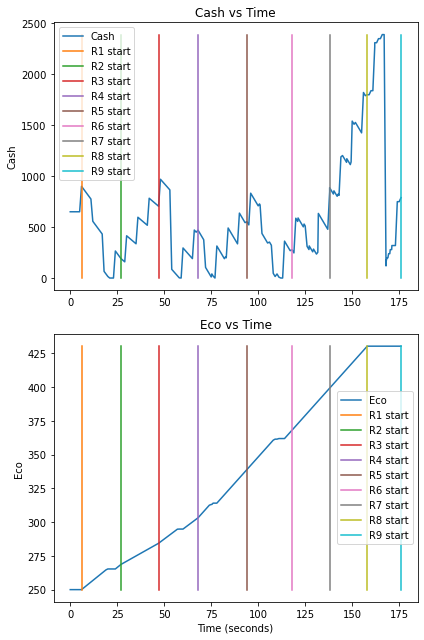

In [170]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.0,
    'Game Round': 0,
}

game_state = GameState(initial_state_game)

game_state.buy_queue = [
    [buyDefense(450, min_buy_time = game_state.computeTimeFromRound(1))], #Buy Quincy 
    [buyDefense(605)], #Buy 020 Tack
    [buyFarm()], #Buy the farm 
    [buyDefense(550)], #Upgrade to a 220 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade the farm to 100
    [buyDefense(605)], #Upgrade to 230 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade to 200 farm
    [upgradeFarm(0, 0, buffer = 0)]] #Upgrade to 300 farm

game_state.eco_queue = [
    (game_state.computeTimeFromRound(1), 'Grouped Reds'),
    (game_state.computeTimeFromRound(2), 'Spaced Greens',),
    (game_state.computeTimeFromRound(3), 'Spaced Yellows'),
    (game_state.computeTimeFromRound(4), 'Spaced Pinks',),
    (game_state.computeTimeFromRound(8), 'Zero',)
]

game_state.fastForward(target_round = 9)

game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'quincy_tfw')

In [60]:
writeLog(game_state.logs)

## The pre-round 20 BRF

We now consider a scenario typical of farm play where the user attempts to purchase BRF prior to the start of round 20.
In this scenario, we assume that the player on R18 has achieved 1 x 320 and 1 x 203 farms, 1200 eco, and intends to sell the 203 farm so as to afford the 420 farm. We assume that the player does *not* eco during this time period.

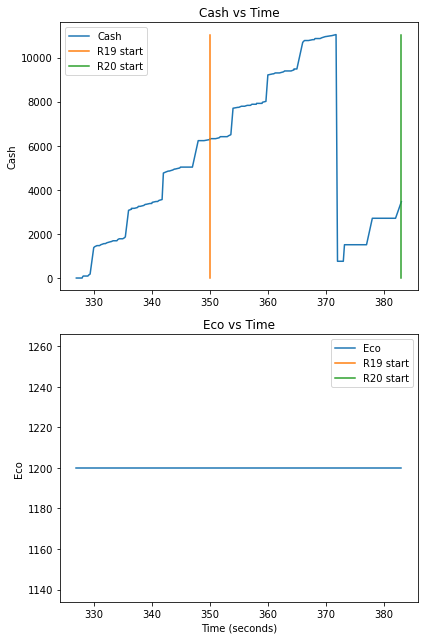

In [171]:
initial_state_game = {
    'Cash': 0,
    'Eco': 1200,
    'Eco Send': 'Zero',
    'Stall Factor': 0,
    'Game Round': 18
}

game_state = GameState(initial_state_game)

game_state.farms = {
    0: initFarm(0, upgrades = [3,2,0]), 
    1: initFarm(0, upgrades = [2,0,3])
}
game_state.key = len(game_state.farms)

game_state.buy_queue = [
    [sellFarm(1), upgradeFarm(0, 0, buffer = 0)]
]

game_state.fastForward(target_round = 20)
game_state.viewCashEcoHistory()

## Case 2A: Optimizing the Pre-R20 BRF (Needs to be fixed)

In the above example, we see that the BRF is actually afforded with plenty of time to spare. However, in high-level play, players may see it desirable in this given mini-scenario to eco as much as possible while still being able to afford the 420 farm in time for R20.

In this extension of Case 2, we determine the longest amount of time that can be spent eco'ing grouped blacks while still being able to afford a pre-R20 BRF.

In [173]:
def foo(stop_time):
    initial_state_game = {
        'Cash': 0,
        'Eco': 1200,
        'Eco Send': 'Grouped Blacks',
        'Stall Factor': 0,
        'Game Round': 18
    }

    game_state = GameState(initial_state_game)

    game_state.farms = {
        0: initFarm(0, upgrades = [3,2,0]), 
        1: initFarm(0, upgrades = [2,0,3])
    }
    game_state.key = len(game_state.farms)

    game_state.buy_queue = [
        [sellFarm(1), upgradeFarm(0, 0, buffer = 0)]
    ]

    game_state.eco_queue = [
        (stop_time,'Zero')
    ]

    game_state.fastForward(target_round = 20)
    
    return game_state.cash - 11480

#Next, let's attempt to find the zero of foo using bisection method
a = game_state.computeTimeFromRound(18)
b = game_state.computeTimeFromRound(19.999)
iterations = 20

for i in range(iterations):
    c = 0.5*(a+b)
    if foo(a)*foo(c) < 0:
        b = c
    else:
        a = c

c = 0.5*(a+b)

initial_state_game = {
        'Cash': 0,
        'Eco': 1200,
        'Eco Send': 'Grouped Blacks',
        'Stall Factor': 0,
        'Game Round': 18
}
game_state = GameState(initial_state_game)

round_of_interest = game_state.getRoundFromTime(c)
time_into_round = c - game_state.round_starts[round_of_interest]
print("The optimal time to stop eco'ing is %s"%(np.round(c,2)))
print("That is, the player should stop eco'ing %s seconds into round %s"%(np.round(time_into_round,2),round_of_interest))

The optimal time to stop eco'ing is 382.97
That is, the player should stop eco'ing 32.97 seconds into round 19


In [32]:
lines = ['Readme', 'How to write text files in Python']
with open('readme.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [49]:
for i in range(6,6):
    print(i)

## Tigerz's Experiment (Needs to be fixed)

In this experiment, tigerz72 considers the impact of choosing to eco spaced yellows in place of grouped blues during rounds 2 and 3 of a typical battles 2 match. We run the experiment until the start of round 8. tigerz concludes unless the game goes late (R26+) that it is worth the cash/eco tradeoff to go spaced yellows early.

Current Cash and Eco: (3293.0,817.0)


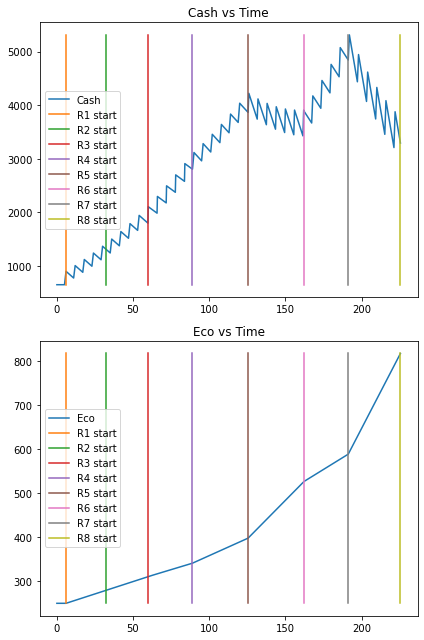

In [12]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.75,
    'Game Round': 0,
    'Debug': False
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)

game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)

game_state.changeEcoSend('Spaced Yellows')
game_state.advanceGameState(target_round=4)

game_state.changeEcoSend('Spaced Pinks')
game_state.advanceGameState(target_round=5)

game_state.changeEcoSend('Grouped Greens')
game_state.advanceGameState(target_round=6)

game_state.changeEcoSend('Spaced Blacks')
game_state.advanceGameState(target_round=7)

game_state.changeEcoSend('Grouped Yellows')
game_state.advanceGameState(target_round=8)



game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))

Current Cash and Eco: (3191.0,835.0)


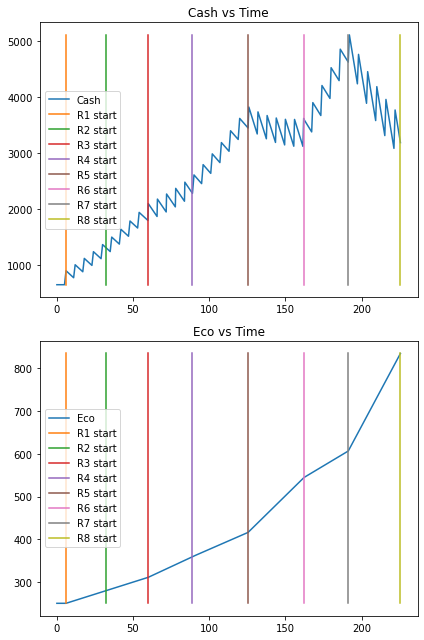

In [13]:
initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Stall Factor': 0.75,
    'Game Round': 0,
    'Debug': False
}
game_state = GameState(initial_state_game)
game_state.advanceGameState(target_round=1)

game_state.changeEcoSend('Grouped Reds')
game_state.advanceGameState(target_round=3)

game_state.changeEcoSend('Grouped Blues')
game_state.advanceGameState(target_round=4)

game_state.changeEcoSend('Spaced Pinks')
game_state.advanceGameState(target_round=5)

game_state.changeEcoSend('Grouped Greens')
game_state.advanceGameState(target_round=6)

game_state.changeEcoSend('Spaced Blacks')
game_state.advanceGameState(target_round=7)

game_state.changeEcoSend('Grouped Yellows')
game_state.advanceGameState(target_round=8)



game_state.viewCashEcoHistory()
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))